# Causal Inference for Churn Test: Breadth of Engagement AB Test Results Analysis

## Preparation

pip install causalml

### Dependencies

pip install snowflake-snowpark-python
pip install pandas
pip install doubleml
pip install scikit-learn
pip install "snowflake-connector-python[pandas]"

### Import Libraries

In [1]:
#Snowflake Connections
import boto3
import json
from snowflake.snowpark import Session
import yaml

#Basic Libraries
import pandas as pd
import numpy as np
from itertools import product
import pickle
from pandas.api.types import CategoricalDtype


#DoubleML Model Libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

#OLS Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

#Uplift Modeling
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import auuc_score, qini_score



#plots
import seaborn as sns
import matplotlib.pyplot as plt


from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import auuc_score, qini_score

from matplotlib.colors import PowerNorm
import os





/home/sagemaker-user/ucl_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


### Import Entitlement Keys to Filter Users that was already within the A/B test sample

In [2]:
keys = pd.read_csv('keys_test.csv')
keys

,Unnamed: 0,ENTITLEMENT_KEY
0,0,1.056268e+19
1,1,1.167022e+19
2,2,2.577932e+17
3,3,1.527679e+19
4,4,2.144048e+18
...,...,...
130827,130827,8.609788e+18
130828,130828,1.560948e+19
130829,130829,4.682949e+17
130830,130830,6.361097e+18


## Import Data from Snowflake

In [3]:
# Get Snowflake credentials from AWS Secrets Manager
SECRET_NAME = "" 

session = boto3.session.Session()
client = session.client(
    service_name='secretsmanager'
)


get_secret_value_response = client.get_secret_value(SecretId=SECRET_NAME)
secret = get_secret_value_response['SecretString']
snf_config = json.loads(secret)

# Create Snowflake connection
session = Session.builder.configs(snf_config).create()

query = f"""
select *
from DERIVED.FACT_CUSTOMER_ENGAGEMENT_ROLLING
where ROLLING_FLAG = 'ROLLING_30'
  and CALENDAR_DATE = '2024-12-27'
  and ENTITLEMENT_PRODUCT_NAME = 'TE.DIGITAL'
  and ENTITLEMENT_RATEPLAN_TERM = 'Annual'
  and TOTAL_SECTION_READ_CNT < 2
limit 200000


"""

try:
    df = session.sql(query).to_pandas()
finally:
    session.close()

df


,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,...,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,003J5000001qy4hIAA,2024-12-27,1.572663e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y1
1,0033z00002rkzelAAA,2024-12-27,6.084274e+18,UK,United Kingdom,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
2,0033z00003Dov7zAAB,2024-12-27,1.436416e+19,ASIA,China,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y3
3,0033z0000352a4PAAQ,2024-12-27,4.159048e+17,CEMEA,Germany,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
4,0033z000030rrloAAA,2024-12-27,1.720538e+19,UK,United Kingdom,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179073,0033z00002nVOT2AAO,2024-12-27,1.741271e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
179074,0033z000037fh3cAAA,2024-12-27,7.496140e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y3
179075,0033z0000354GC9AAM,2024-12-27,4.147161e+18,CEMEA,Germany,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
179076,0033z000031DzM7AAK,2024-12-27,1.627378e+18,CEMEA,Ireland,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+


In [22]:
df.to_csv('outsample_data.csv', index=False)

## Import Data from CSV

In [3]:
df=pd.read_csv('outsample_data.csv')
df

,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,...,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,003J5000001qy4hIAA,2024-12-27,1.572663e+19,NaN,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y1
1,0033z00002rkzelAAA,2024-12-27,6.084274e+18,UK,United Kingdom,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
2,0033z00003Dov7zAAB,2024-12-27,1.436416e+19,ASIA,China,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y3
3,0033z0000352a4PAAQ,2024-12-27,4.159048e+17,CEMEA,Germany,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
4,0033z000030rrloAAA,2024-12-27,1.720538e+19,UK,United Kingdom,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179073,0033z00002nVOT2AAO,2024-12-27,1.741271e+19,NaN,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
179074,0033z000037fh3cAAA,2024-12-27,7.496140e+18,NaN,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y3
179075,0033z0000354GC9AAM,2024-12-27,4.147161e+18,CEMEA,Germany,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
179076,0033z000031DzM7AAK,2024-12-27,1.627378e+18,CEMEA,Ireland,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+


In [4]:
#Filter data outside A/B test sample
filtered_df = df[~df['ENTITLEMENT_KEY'].isin(keys['ENTITLEMENT_KEY'])]
filtered_df

,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,...,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,003J5000001qy4hIAA,2024-12-27,1.572663e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y1
3,0033z0000352a4PAAQ,2024-12-27,4.159048e+17,CEMEA,Germany,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
4,0033z000030rrloAAA,2024-12-27,1.720538e+19,UK,United Kingdom,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y4
6,0033z00003Hz2N0AAJ,2024-12-27,1.446875e+19,CEMEA,Germany,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y2
7,0033z00002orsZzAAI,2024-12-27,2.547580e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179071,0033z00002rv1P8AAI,2024-12-27,2.584165e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y3
179072,0033z00003RuJKSAA3,2024-12-27,4.930616e+18,ASIA,"Korea, Republic of",Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y2
179073,0033z00002nVOT2AAO,2024-12-27,1.741271e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+
179076,0033z000031DzM7AAK,2024-12-27,1.627378e+18,CEMEA,Ireland,Direct,AR,TE.DIGITAL,Annual,Owned,...,0,0,0,0,0,0,0,0,0,Y5+


## Data Wrangling

### Merging and Filtering

In [5]:

pd.set_option('display.max_rows', 100)  # or None for unlimit
pd.set_option('display.max_columns', None)  # or None for unlimited


In [6]:
df_merged_complete = df.copy()
df_merged_complete

,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,ENTITLEMENT_STUDENT_FLAG,ENTITLEMENT_TRIALIST_FLAG,ENTITLEMENT_FREE_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,TOTAL_SERVED_VOLUME,TOTAL_ENGAGEMENT_COUNT,WEBSITE_VISIT_CNT,WEBSITE_ARTICLE_VIEW_VISIT_CNT,WEBSITE_AUDIO_PLAY_VISIT_CNT,WEBSITE_VIDEO_PLAY_VISIT_CNT,WEBSITE_PAGE_VIEW_CNT,WEBSITE_ARTICLE_VIEW_CNT,WEBSITE_AUDIO_PLAY_CNT,WEBSITE_VIDEO_PLAY_CNT,WEBSITE_VIDEO_PLAY_WEBINAR_CNT,COREAPP_VISIT_CNT,COREAPP_ARTICLE_VIEW_VISIT_CNT,COREAPP_AUDIO_PLAY_VISIT_CNT,COREAPP_VIDEO_PLAY_VISIT_CNT,COREAPP_PAGE_VIEW_CNT,COREAPP_ARTICLE_VIEW_CNT,COREAPP_AUDIO_PLAY_CNT,COREAPP_VIDEO_PLAY_CNT,COREAPP_VIDEO_PLAY_WEBINAR_CNT,LEGACYAPP_VISIT_CNT,LEGACYAPP_ARTICLE_VIEW_VISIT_CNT,LEGACYAPP_AUDIO_PLAY_VISIT_CNT,LEGACYAPP_VIDEO_PLAY_VISIT_CNT,LEGACYAPP_PAGE_VIEW_CNT,LEGACYAPP_ARTICLE_VIEW_CNT,LEGACYAPP_AUDIO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOAPP_VISIT_CNT,ESPRESSOAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOAPP_PAGE_VIEW_CNT,ESPRESSOAPP_ARTICLE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOLEGACYAPP_VISIT_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_PAGE_VIEW_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,NEWSLETTER_CONTENT_OPEN_CNT,NEWSLETTER_CLICKBASED_OPEN_CNT,WEBINAR_ATTEND_CNT,ROLLING_FLAG,SLOT_ID,SUBMISSION_ID,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,ENTITLEMENT_PRODUCT_GRANULAR_NAME,NUMBER_OF_DAYS_ACTIVE,TOTAL_SECTION_READ_CNT,SECTION_LIST,ENGAGEMENT_SCORE,SCORE_WEIGHTED_CONSUMPTION,SCORE_COREAPP_ARTICLE,SCORE_COREAPP_AUDIO,SCORE_COREAPP_VIDEO,SCORE_WEBSITE_ARTICLE,SCORE_WEBSITE_AUDIO,SCORE_WEBSITE_VIDEO,SCORE_NEWSLETTER_CONTENT,SCORE_WEBINAR_ATTEND,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,NEWSLETTER_ESPRESSO_OPEN_CNT,NEWSLETTER_COVERSTORY_OPEN_CNT,NEWSLETTER_MONEYTALKS_OPEN_CNT,NEWSLETTER_CHECKSANDBALANCE_OPEN_CNT,NEWSLETTER_CLIMATEISSUE_OPEN_CNT,NEWSLETTER_SIMPLYSCIENCE_OPEN_CNT,NEWSLETTER_OFFTHECHARTS_OPEN_CNT,NEWSLETTER_BOTTOMLINE_OPEN_CNT,NEWSLETTER_DRUMTOWER_OPEN_CNT,NEWSLETTER_BLIGHTY_OPEN_CNT,NEWSLETTER_ANALYSING_AFRICA_OPEN_CNT,NEWSLETTER_EXTRAORDINARYSTORY_OPEN_CNT,NEWSLETTER_WARROOM_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_SUNDAY_OPEN_CNT,NEWSLETTER_THISWEEK_OPEN_CNT,NEWSLETTER_THISWEEK_SATURDAY_OPEN_CNT,NEWSLETTER_ESSENTIALINDIA_OPEN_CNT,NEWSLETTER_CAFEEUROPA_OPEN_CNT,NEWSLETTER_MIDDLE_EAST_DISPATCH_OPEN_CNT,NEWSLETTER_EL_BOLETIN_OPEN_CNT,NEWSLETTER_THE_US_IN_BRIEF_OPEN_CNT,NEWSLETTER_PLOTTWIST_OPEN_CNT,NEWSLETTER_OTHER_OPEN_CNT,NUMBER_OF_DAYS_ACTIVE_WEB,NUMBER_OF_DAYS_ACTIVE_APP,NUMBER_OF_DAYS_ACTIVE_NEWSLETTER,NUMBER_OF_DAYS_ACTIVE_WEBINAR,PAGE_VIEW_CNT,ARTICLE_VIEW_CNT,AUDIO_PLAY_CNT,VIDEO_PLAY_CNT,WEBSITE_ARTICLE_REGULAR_VIEW_CNT,WEBSITE_ARTICLE_ESPRESSO_VIEW_CNT,WEBSITE_ARTICLE_INTERACTIVE_VIEW_CNT,WEBSITE_AUDIO_PLAY_REGULAR_CNT,WEBSITE_AUDIO_PLAY_PODCAST_CNT,WEBSITE_VIDEO_PLAY_REGULAR_CNT,COREAPP_ARTICLE_REGULAR_VIEW_CNT,COREAPP_ARTICLE_ESPRESSO_VIEW_CNT,COREAPP_ARTICLE_INTERACTIVE_VIEW_CNT,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,003J5000001qy4hIAA,2024-12-27,1.572663e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,Regular,Non-Trialist,P

In [7]:
df_merged_complete['CONTROL_TEST'] = 'CONTROL'
df_merged_complete['TOTAL_SECTIONS_READ_PREV_1M'] = df_merged_complete['TOTAL_SECTION_READ_CNT']
df_merged_complete['OPEN_FLAG'] = 0
df_merged_complete['CLICK_FLAG'] = 0 
df_merged_complete['TOTAL_SECTIONS_READ_FWD_2W'] = 0 
df_merged_complete['ANNUAL_2_READS'] = 0

In [8]:
#Only Use Necessary Columns
df_filtered = df_merged_complete[[
    'ENTITLEMENT_KEY', 
    'CONTROL_TEST', 
    'ENTITLEMENT_RECIPIENT_REGION_CODE', 
    'ENTITLEMENT_RATEPLAN_TERM', 
    'ENTITLEMENT_STUDENT_FLAG', 
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'ENTITLEMENT_RENEWAL_CATEGORY',
    'SUBSCRIBER_TENURE_DAYS', 
    'SCORE_BREADTH',
    'SCORE_FREQUENCY',
    'WEIGHTED_CONSUMPTION',
    'TOTAL_SECTIONS_READ_PREV_1M',
    'OPEN_FLAG',
    'CLICK_FLAG',
    'TOTAL_SECTIONS_READ_FWD_2W',
    'ANNUAL_2_READS']]
df_filtered     

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.572663e+19,CONTROL,NA,Annual,Regular,False,AR Annual CP1,218.0,0.002,0.002,0.0,0,0,0,0,0
1,6.084274e+18,CONTROL,UK,Annual,Regular,False,AR Annual CP3+,1400.0,0.002,0.986,114.7,0,0,0,0,0
2,1.436416e+19,CONTROL,ASIA,Annual,Regular,False,AR Annual CP3+,832.0,0.002,0.002,0.0,0,0,0,0,0
3,4.159048e+17,CONTROL,CEMEA,Annual,Student,False,AR Annual CP3+,2189.0,0.002,0.002,0.0,0,0,0,0,0
4,1.720538e+19,CONTROL,UK,Annual,Regular,False,AR Annual CP3+,1266.0,0.002,0.002,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179073,1.741271e+19,CONTROL,NA,Annual,Regular,False,AR Annual CP3+,3729.0,0.027,0.005,2.2,1,0,0,0,0
179074,7.496140e+18,CONTROL,NA,Annual,Regular,False,AR Annual CP3+,1021.0,0.002,0.990,129.5,0,0,0,0,0
179075,4.147161e+18,CONTROL,CEMEA,Annual,Student,False,AR Annual CP3+,1129.0,0.002,0.992,266.4,0,0,0,0,0
179076,1.627378e+18,CONTROL,CEMEA,Annual,Regular,False,AR Annual CP3+,4562.0,0.002,0.002,0.0,0,0,0,0,0


### Data Imputation

In [9]:
# Change Treatment to Binary
df_filtered['CONTROL_TEST'] = df_filtered['CONTROL_TEST'].map({'CONTROL':0, 'TEST':1})
#df_filtered.rename(columns={'SUBSCRIBER_TENURE_YEARS_x': 'SUBSCRIBER_TENURE_YEARS'}, inplace=True)


#Count Nan Rows
nan_rows = df_filtered[df_filtered.isnull().any(axis=1)]
num_nan_rows = len(nan_rows)
print(num_nan_rows)

#Delete Nan Rows
df_filtered = df_filtered.dropna()
df_filtered = df_filtered.reset_index(drop=True)


#Delete rows where SUBSCRIBER_TENURE_YEARS is Uknown
#df_filtered = df_filtered[df_filtered['SUBSCRIBER_TENURE_YEARS'] != 'Unknown']
df_filtered

87


/tmp/ipykernel_5720/648054361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CONTROL_TEST'] = df_filtered['CONTROL_TEST'].map({'CONTROL':0, 'TEST':1})


,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.572663e+19,0,NA,Annual,Regular,False,AR Annual CP1,218.0,0.002,0.002,0.0,0,0,0,0,0
1,6.084274e+18,0,UK,Annual,Regular,False,AR Annual CP3+,1400.0,0.002,0.986,114.7,0,0,0,0,0
2,1.436416e+19,0,ASIA,Annual,Regular,False,AR Annual CP3+,832.0,0.002,0.002,0.0,0,0,0,0,0
3,4.159048e+17,0,CEMEA,Annual,Student,False,AR Annual CP3+,2189.0,0.002,0.002,0.0,0,0,0,0,0
4,1.720538e+19,0,UK,Annual,Regular,False,AR Annual CP3+,1266.0,0.002,0.002,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178986,1.741271e+19,0,NA,Annual,Regular,False,AR Annual CP3+,3729.0,0.027,0.005,2.2,1,0,0,0,0
178987,7.496140e+18,0,NA,Annual,Regular,False,AR Annual CP3+,1021.0,0.002,0.990,129.5,0,0,0,0,0
178988,4.147161e+18,0,CEMEA,Annual,Student,False,AR Annual CP3+,1129.0,0.002,0.992,266.4,0,0,0,0,0
178989,1.627378e+18,0,CEMEA,Annual,Regular,False,AR Annual CP3+,4562.0,0.002,0.002,0.0,0,0,0,0,0


In [28]:
prediction_df = df_filtered.copy()
prediction_df

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.5726628983177777e+19,0,NA,Annual,Regular,False,AR Annual CP1,218.0,0.002,0.002,0.0,0,0,0,0,0
1,6.084274327830889e+18,0,UK,Annual,Regular,False,AR Annual CP3+,1400.0,0.002,0.986,114.7,0,0,0,0,0
2,1.4364159920289583e+19,0,ASIA,Annual,Regular,False,AR Annual CP3+,832.0,0.002,0.002,0.0,0,0,0,0,0
3,4.159047739088491e+17,0,CEMEA,Annual,Student,False,AR Annual CP3+,2189.0,0.002,0.002,0.0,0,0,0,0,0
4,1.7205375358423384e+19,0,UK,Annual,Regular,False,AR Annual CP3+,1266.0,0.002,0.002,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178986,1.7412709570805398e+19,0,NA,Annual,Regular,False,AR Annual CP3+,3729.0,0.027,0.005,2.2,1,0,0,0,0
178987,7.496140211339782e+18,0,NA,Annual,Regular,False,AR Annual CP3+,1021.0,0.002,0.990,129.5,0,0,0,0,0
178988,4.14716115625386e+18,0,CEMEA,Annual,Student,False,AR Annual CP3+,1129.0,0.002,0.992,266.4,0,0,0,0,0
178989,1.6273779604538834e+18,0,CEMEA,Annual,Regular,False,AR Annual CP3+,4562.0,0.002,0.002,0.0,0,0,0,0,0


## Outsample Prediction

In [29]:
#Load Trained Uplift Model
with open('uplift_rf_model.pkl', 'rb') as f:
    uplift_rf_loaded = pickle.load(f)

In [30]:
cat_cols = [
    'ENTITLEMENT_RECIPIENT_REGION_CODE',
    'ENTITLEMENT_RATEPLAN_TERM',
    'ENTITLEMENT_STUDENT_FLAG',
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'ENTITLEMENT_RENEWAL_CATEGORY',
]

prediction_df[cat_cols] = prediction_df[cat_cols].astype('category')

prediction_df = prediction_df.drop(columns=['TOTAL_SECTIONS_READ_FWD_2W'])



In [31]:
X_pred = pd.get_dummies(prediction_df.drop(columns=['ENTITLEMENT_KEY']), drop_first=True)


In [32]:
y_pred = uplift_rf_loaded.predict(X_pred.values)


In [33]:
y_pred

array([[ 0.01281701],
       [-0.00875826],
       [ 0.01281701],
       ...,
       [ 0.01380896],
       [ 0.01380896],
       [ 0.01281701]], shape=(178991, 1))

In [34]:
uplift_results = pd.DataFrame(y_pred)
uplift_results.columns = ['uplift']
# Ensure the index alignment matches between prediction_df and uplift_results
uplift_results_with_key = prediction_df[['ENTITLEMENT_KEY']].reset_index(drop=True)
uplift_results = pd.concat([uplift_results_with_key, uplift_results.reset_index(drop=True)], axis=1)
uplift_results

,ENTITLEMENT_KEY,uplift
0,1.5726628983177777e+19,0.012817
1,6.084274327830889e+18,-0.008758
2,1.4364159920289583e+19,0.012817
3,4.159047739088491e+17,0.013809
4,1.7205375358423384e+19,-0.008758
...,...,...
178986,1.7412709570805398e+19,0.012817
178987,7.496140211339782e+18,0.012817
178988,4.14716115625386e+18,0.013809
178989,1.6273779604538834e+18,0.013809


In [35]:
uplift_results.uplift.value_counts()

uplift
 0.012817    109993
 0.013809     35473
-0.008758     26076
 0.023135      6894
 0.057046       358
 0.058038       115
 0.029615        56
 0.067364        26
Name: count, dtype: int64

In [36]:
df_filtered['ENTITLEMENT_KEY'] = df_filtered['ENTITLEMENT_KEY'].astype(str)
uplift_results['ENTITLEMENT_KEY'] = uplift_results['ENTITLEMENT_KEY'].astype(str)

merged = df_filtered.merge(uplift_results[['uplift', 'ENTITLEMENT_KEY']], on='ENTITLEMENT_KEY', how='left')

merged

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS,uplift
0,1.5726628983177777e+19,0,NA,Annual,Regular,False,AR Annual CP1,218.0,0.002,0.002,0.0,0,0,0,0,0,0.012817
1,6.084274327830889e+18,0,UK,Annual,Regular,False,AR Annual CP3+,1400.0,0.002,0.986,114.7,0,0,0,0,0,-0.008758
2,1.4364159920289583e+19,0,ASIA,Annual,Regular,False,AR Annual CP3+,832.0,0.002,0.002,0.0,0,0,0,0,0,0.012817
3,4.159047739088491e+17,0,CEMEA,Annual,Student,False,AR Annual CP3+,2189.0,0.002,0.002,0.0,0,0,0,0,0,0.013809
4,1.7205375358423384e+19,0,UK,Annual,Regular,False,AR Annual CP3+,1266.0,0.002,0.002,0.0,0,0,0,0,0,-0.008758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178986,1.7412709570805398e+19,0,NA,Annual,Regular,False,AR Annual CP3+,3729.0,0.027,0.005,2.2,1,0,0,0,0,0.012817
178987,7.496140211339782e+18,0,NA,Annual,Regular,False,AR Annual CP3+,1021.0,0.002,0.990,129.5,0,0,0,0,0,0.012817
178988,4.14716115625386e+18,0,CEMEA,Annual,Student,False,AR Annual CP3+,1129.0,0.002,0.992,266.4,0,0,0,0,0,0.013809
178989,1.6273779604538834e+18,0,CEMEA,Annual,Regular,False,AR Annual CP3+,4562.0,0.002,0.002,0.0,0,0,0,0,0,0.013809


### Rank Users based on Predicted Uplift and Bin into Deciles

In [37]:
# Sort by uplift descending
merged = merged.sort_values(by='uplift', ascending=False).reset_index(drop=True)

# Calculate rank
merged['rank'] = merged['uplift'].rank(method='first', ascending=False)

# Try to bin into 10 deciles — drop duplicate edges
merged['decile'] = pd.qcut(merged['rank'], 10, labels=False, duplicates='drop')

# Match decile labels dynamically based on the number of unique bins
unique_deciles = merged['decile'].nunique()
decile_labels = [
    "top 10%", "top 10-20%", "top 20-30%", "top 30-40%", "top 40-50%", 
    "top 50-60%", "top 60-70%", "top 70-80%", "top 80-90%", "bottom 10%"
][:unique_deciles]

merged['decile_label'] = merged['decile'].map(lambda x: decile_labels[int(x)] if pd.notna(x) else None)
merged


In [39]:
merged.uplift.value_counts()

uplift
 0.012817    109993
 0.013809     35473
-0.008758     26076
 0.023135      6894
 0.057046       358
 0.058038       115
 0.029615        56
 0.067364        26
Name: count, dtype: int64

## Simulated Uplift Gain Curve

In [42]:
df.to_csv('outsample_prediction_results2.csv')

In [4]:
merged=pd.read_csv('outsample_prediction_result.csv')
merged

,Unnamed: 0,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,...,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS,uplift,rank,decile,decile_label,cumulative_uplift,percentile
0,0,1.044486e+19,0,NaN,Annual,Regular,False,AR Annual CP3+,4653.0,0.027,...,0,0,0,0,0.156553,1.0,0,top 10%,0.156553,0.000006
1,1,6.467457e+18,0,NaN,Annual,Regular,False,Gift CP1,1.0,0.002,...,0,0,0,0,0.146039,2.0,0,top 10%,0.302591,0.000011
2,2,1.175289e+19,0,NaN,Annual,Student,False,AR Annual CP1,87.0,0.027,...,0,0,0,0,0.137836,3.0,0,top 10%,0.440428,0.000017
3,3,9.857062e+18,0,NaN,Annual,Student,False,AR Annual CP1,95.0,0.027,...,0,0,0,0,0.137836,4.0,0,top 10%,0.578264,0.000022
4,4,6.082508e+18,0,NaN,Annual,Regular,True,AR Annual CP2,55.0,0.027,...,0,0,0,0,0.137836,5.0,0,top 10%,0.716100,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178986,178986,8.451517e+18,0,UK,Annual,Regular,False,AR Annual CP3+,812.0,0.027,...,0,0,0,0,-0.205685,178987.0,9,bottom 10%,7228.661849,0.999978
178987,178987,1.653478e+19,0,UK,Annual,Regular,False,AR Annual CP3+,889.0,0.002,...,0,0,0,0,-0.205685,178988.0,9,bottom 10%,7228.456165,0.999983
178988,178988,1.387744e+19,0,UK,Annual,Regular,False,AR Annual CP3+,786.0,0.002,...,0,0,0,0,-0.205685,178989.0,9,bottom 10%,7228.250480,0.999989
178989,178989,6.162168e+18,0,UK,Annual,Regular,False,AR Annual CP3+,996.0,0.002,...,0,0,0,0,-0.205685,178990.0,9,bottom 10%,7228.044795,0.999994


In [7]:
pd.set_option('display.max_columns', None) 
merged

,Unnamed: 0,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS,uplift,rank,decile,decile_label,cumulative_uplift,percentile
0,0,1.044486e+19,0,NaN,Annual,Regular,False,AR Annual CP3+,4653.0,0.027,0.976,345.2,1,0,0,0,0,0.156553,1.0,0,top 10%,0.156553,0.000006
1,1,6.467457e+18,0,NaN,Annual,Regular,False,Gift CP1,1.0,0.002,0.005,675.0,0,0,0,0,0,0.146039,2.0,0,top 10%,0.302591,0.000011
2,2,1.175289e+19,0,NaN,Annual,Student,False,AR Annual CP1,87.0,0.027,0.969,401.8,1,0,0,0,0,0.137836,3.0,0,top 10%,0.440428,0.000017
3,3,9.857062e+18,0,NaN,Annual,Student,False,AR Annual CP1,95.0,0.027,0.976,430.2,1,0,0,0,0,0.137836,4.0,0,top 10%,0.578264,0.000022
4,4,6.082508e+18,0,NaN,Annual,Regular,True,AR Annual CP2,55.0,0.027,0.946,404.3,1,0,0,0,0,0.137836,5.0,0,top 10%,0.716100,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178986,178986,8.451517e+18,0,UK,Annual,Regular,False,AR Annual CP3+,812.0,0.027,0.997,268.4,1,0,0,0,0,-0.205685,178987.0,9,bottom 10%,7228.661849,0.999978
178987,178987,1.653478e+19,0,UK,Annual,Regular,False,AR Annual CP3+,889.0,0.002,0.997,247.9,0,0,0,0,0,-0.205685,178988.0,9,bottom 10%,7228.456165,0.999983
178988,178988,1.387744e+19,0,UK,Annual,Regular,False,AR Annual CP3+,786.0,0.002,0.996,244.2,0,0,0,0,0,-0.205685,178989.0,9,bottom 10%,7228.250480,0.999989
178989,178989,6.162168e+18,0,UK,Annual,Regular,False,AR Annual CP3+,996.0,0.002,0.997,310.8,0,0,0,0,0,-0.205685,178990.0,9,bottom 10%,7228.044795,0.999994


In [8]:
import pandas as pd

# Define bins and labels
tenure_bins = [0, 365, 2*365, 3*365, 4*365, float('inf')]
tenure_labels = ['Y1', 'Y2', 'Y3', 'Y4', 'Y5+']

# Create the categorical column
merged['SUBSCRIBER_TENURE_YEARS'] = pd.cut(
    merged['SUBSCRIBER_TENURE_DAYS'],
    bins=tenure_bins,
    labels=tenure_labels,
    right=False  # interval includes the left, excludes the right (e.g., [0,365))
)



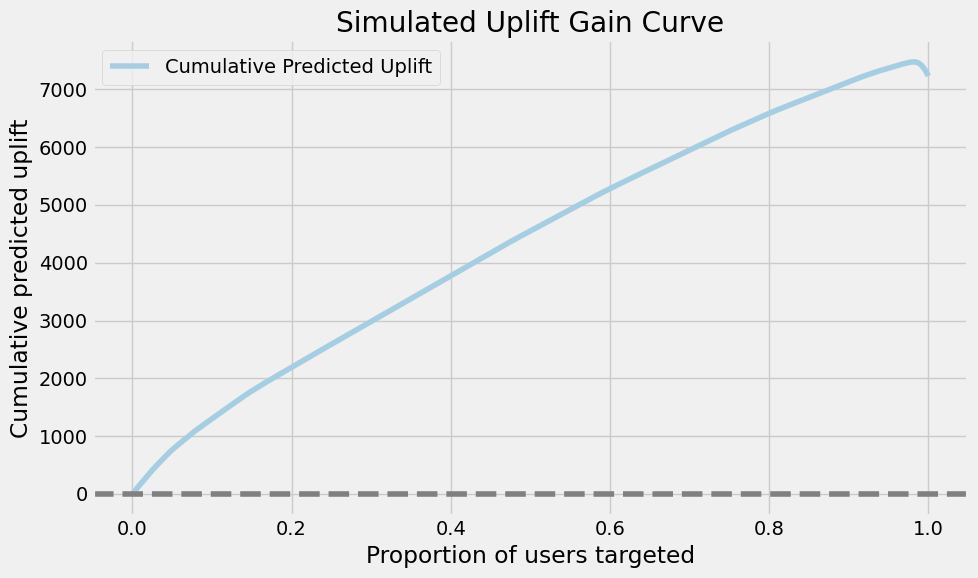

In [9]:
import numpy as np
import matplotlib.pyplot as plt

df = merged.copy()
df = df.sort_values(by='uplift', ascending=False).reset_index(drop=True)
df['cumulative_uplift'] = df['uplift'].cumsum()
df['percentile'] = np.arange(1, len(df)+1) / len(df)

plt.figure(figsize=(10, 6))
plt.plot(df['percentile'], df['cumulative_uplift'], label='Cumulative Predicted Uplift')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Proportion of users targeted")
plt.ylabel("Cumulative predicted uplift")
plt.title("Simulated Uplift Gain Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Sanity Check by Exploring Decile Distribution

In [11]:
# Convert boolean True/False to strings "1"/"0"
merged['IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG'] = (
    merged['IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG']
    .astype(int)   # True → 1, False → 0
    .astype(str)   # Convert to string
)


In [13]:
merged['ENTITLEMENT_RECIPIENT_REGION_CODE'] = merged['ENTITLEMENT_RECIPIENT_REGION_CODE'].fillna('NA')
# Keep all rows where the region is not the string 'Unknown'
merged = merged[merged['ENTITLEMENT_RECIPIENT_REGION_CODE'] != 'Unknown']


/tmp/ipykernel_5655/2621770141.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[decile_col] = df[decile_col].astype(cat_type)


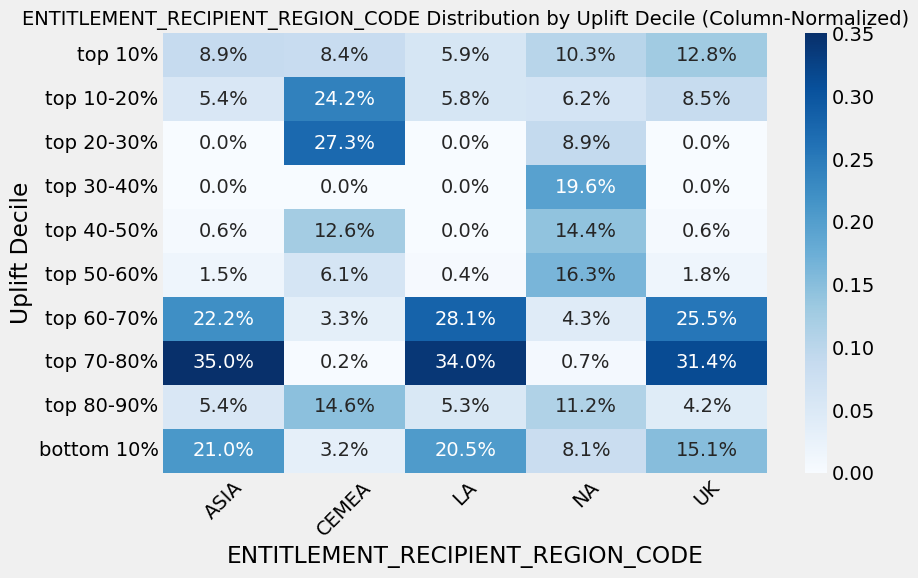

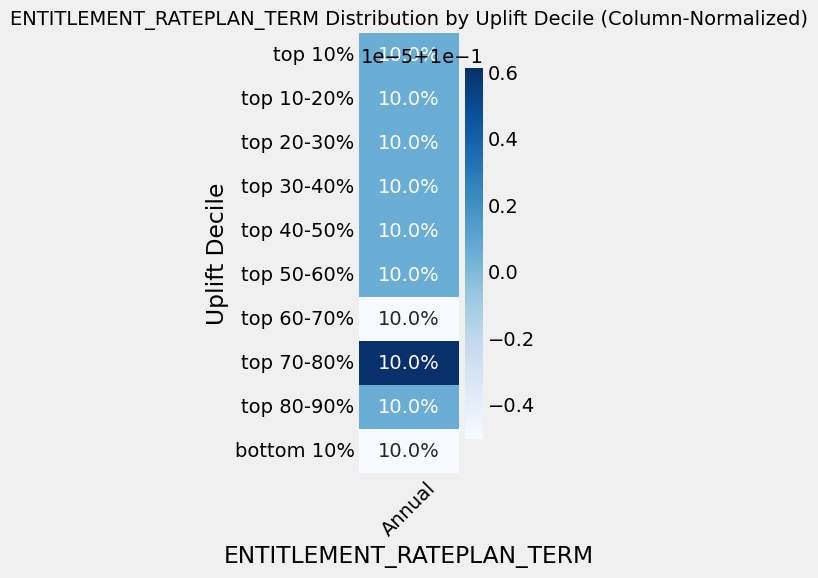

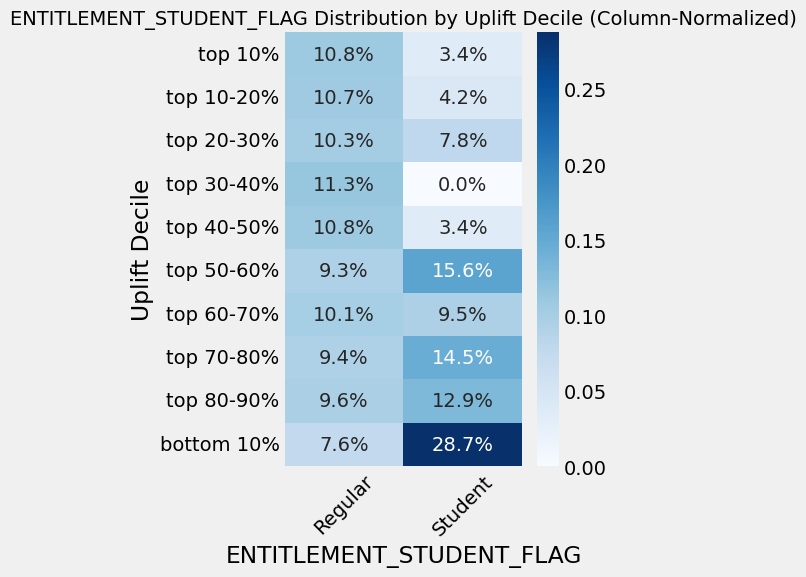

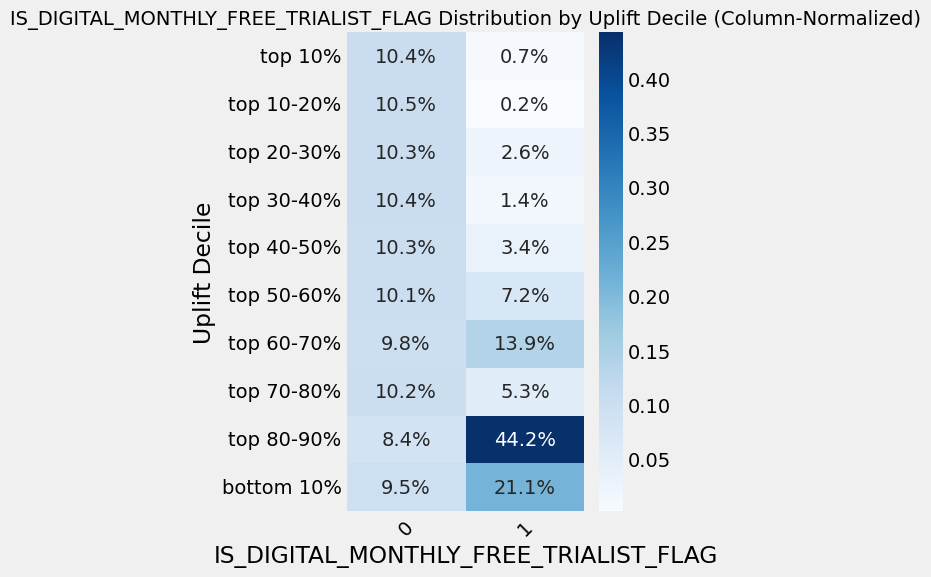

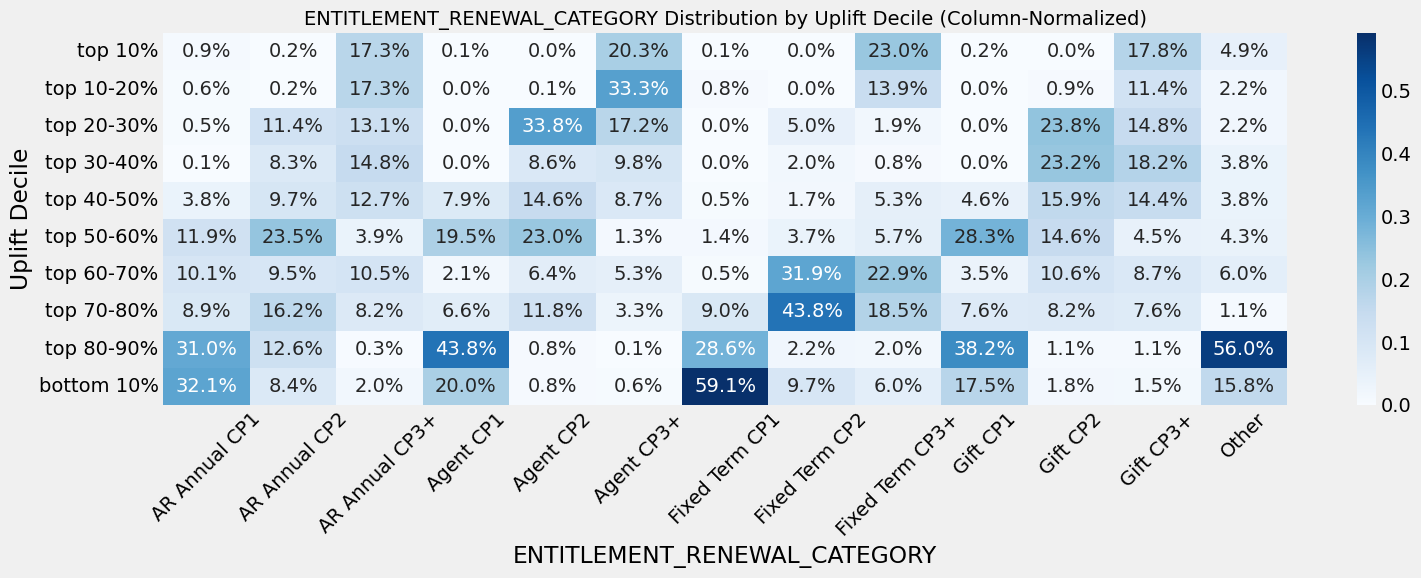

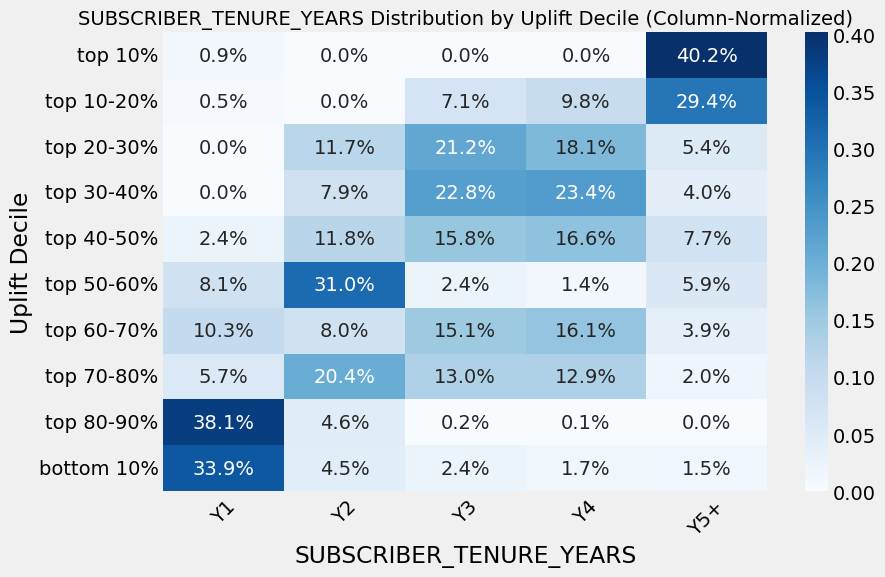

In [15]:
def plot_uplift_heatmaps(df, decile_col='decile_label', max_categories=20):
    """
    Create annotated heatmaps showing how each category is distributed across uplift deciles.
    Percentages are normalized by column (i.e., within each category).
    
    Parameters:
        df (DataFrame): The dataset containing uplift deciles and categorical features.
        decile_col (str): Column containing decile labels.
        max_categories (int): Max number of categories allowed in a column to be included.
    """
    # Define correct decile order
    ordered_labels = [
        "top 10%", "top 10-20%", "top 20-30%", "top 30-40%", "top 40-50%",
        "top 50-60%", "top 60-70%", "top 70-80%", "top 80-90%", "bottom 10%"
    ]
    cat_type = CategoricalDtype(categories=ordered_labels, ordered=True)
    df[decile_col] = df[decile_col].astype(cat_type)

    # Identify relevant categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop(decile_col, errors='ignore')

    for col in cat_cols:
        n_unique = df[col].nunique()
        if n_unique <= max_categories:
            # Normalize by column to show % of each category across deciles
            ctab = pd.crosstab(df[decile_col], df[col], normalize='columns').reindex(ordered_labels)

            plt.figure(figsize=(min(16, 2 + 1.5 * len(ctab.columns)), 6))
            sns.heatmap(ctab, annot=True, fmt=".1%", cmap="Blues", cbar=True)
            plt.title(f"{col} Distribution by Uplift Decile (Column-Normalized)", fontsize=14)
            plt.ylabel("Uplift Decile")
            plt.xlabel(col)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping '{col}' — too many categories ({n_unique})")

# Example usage:
plot_uplift_heatmaps(merged, decile_col='decile_label')


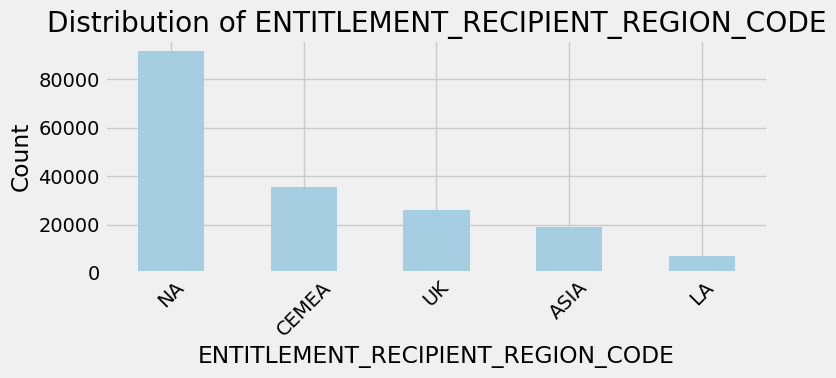

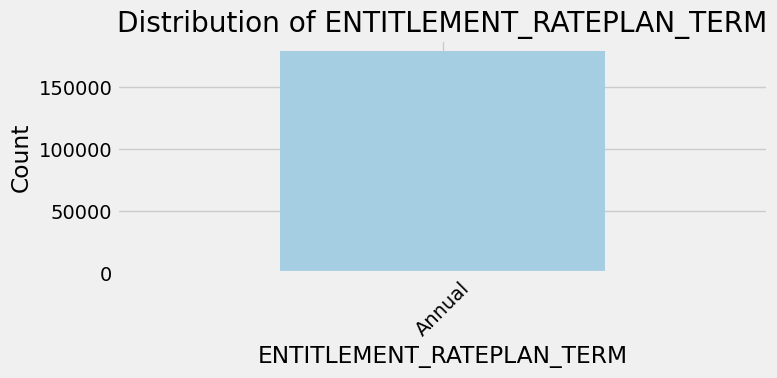

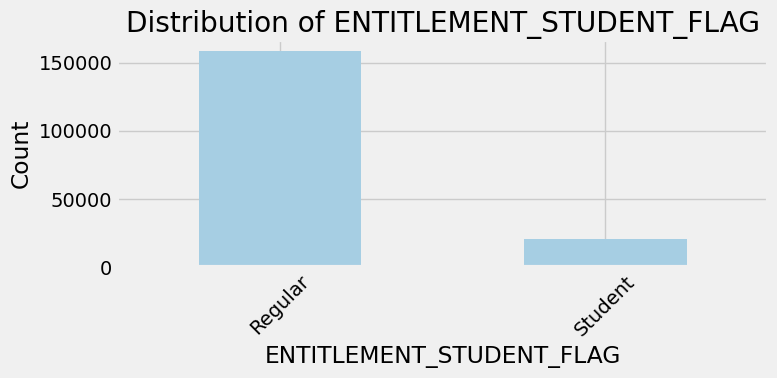

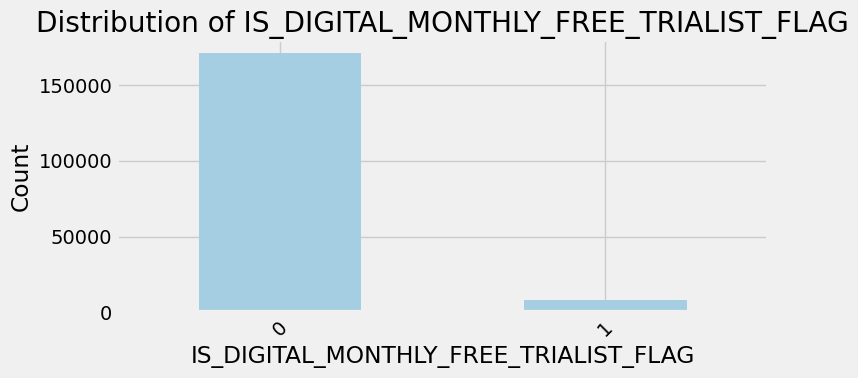

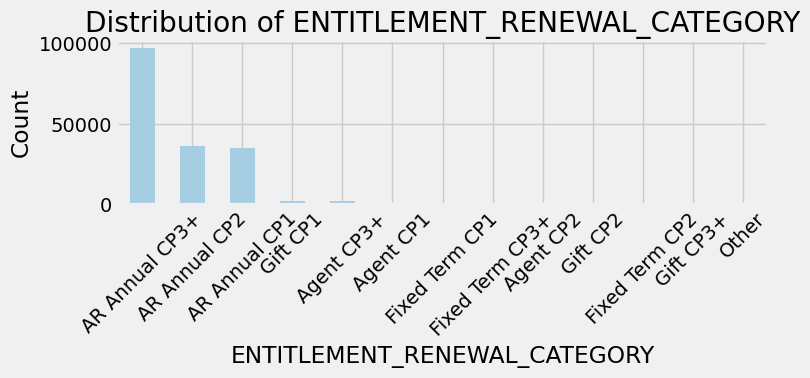

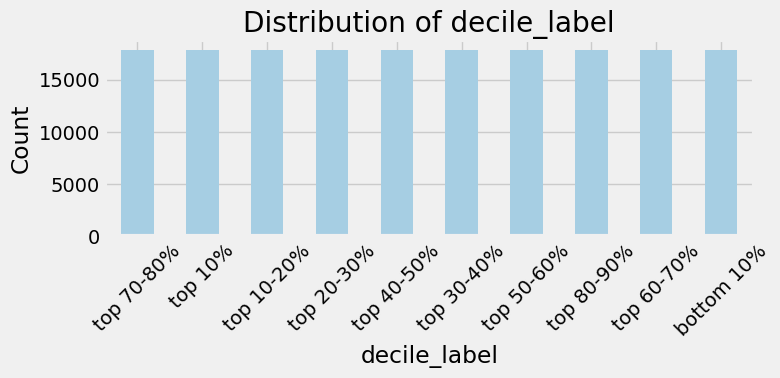

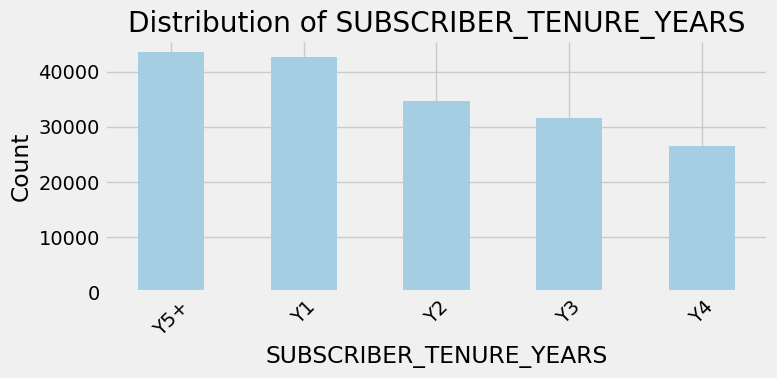

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify categorical columns
categorical_cols = merged.select_dtypes(include=['object', 'category']).columns

# Plot bar graphs for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    merged[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()